# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus_new0']
filenames2 = ['electron_new0']#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500
hadron_weight = 1000

In [3]:
if True:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)

    data2 = pd.read_csv(filepath+f'{filenames2[0]}.csv')
    data2.loc[data2['phi0'] > -99, 'phi0'] = 1
    for ifile in range(1,len(filenames2)):
        idata = pd.read_csv(filepath+f'{filenames2[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 1
        data2 = pd.concat([data2,idata], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)

    data.head()

In [5]:
print(data.size, data.shape)

150411130 (15041113, 10)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


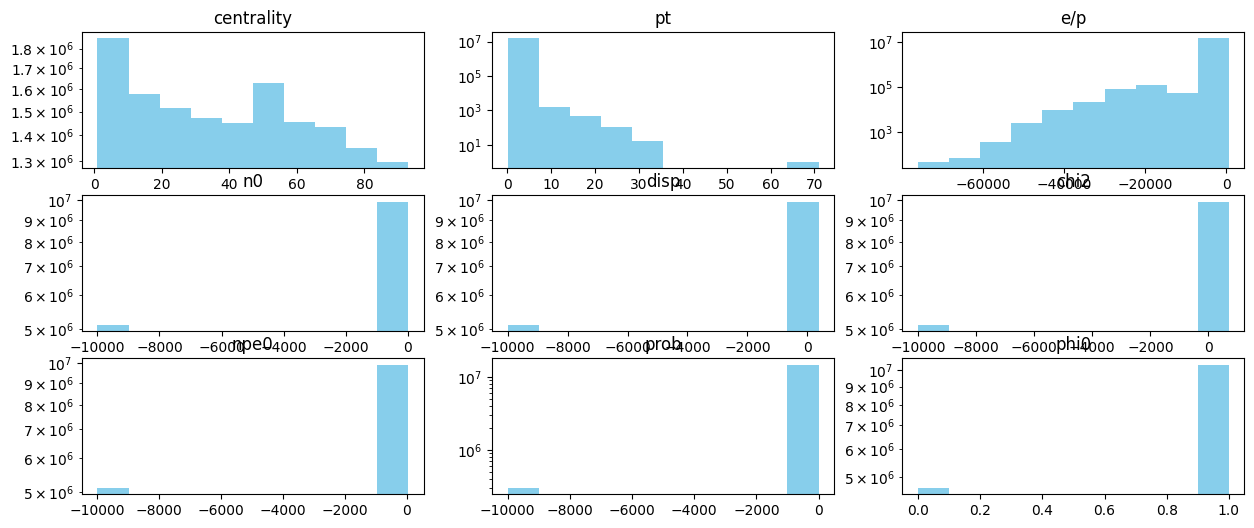

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [10]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

5013704 10027409


In [11]:
X_test

centrality        pt       e/p    n0         disp         chi2  npe0  \
2911362          51  0.440226  0.745580 -9999 -9999.000000 -9999.000000 -9999   
8014571          56  0.693009  0.884242     6     1.813013    37.326202    24   
2015927          43  1.421113  0.944841     5     3.727924    33.809189    13   
2287108          91  1.415284  0.876643     3     1.515067    11.654274     4   
3100759          32  1.026007  1.043921     6     1.071315    51.200401    13   
...             ...       ...       ...   ...          ...          ...   ...   
625224           32  1.075567  0.951901     4     1.300836     4.753257    10   
4994905          45  0.963758  1.117454     5     4.119150    91.640686    11   
7746806          36  0.734581  1.015649     5     1.986330    29.087078    15   
2890821          27  0.411507  0.832581     6     1.713596    30.381594    12   
2480319          24  0.458512  1.000953 -9999 -9999.000000 -9999.000000 -9999   

             prob  
2911362  0.270886  
8014571  0.362064  
2015927  0.994224  
2287108  0.718237  
3100759  0.003365  
...           ...  
625224   0.854417  
4994905  0.931631  
7746806  0.940166  
2890821  0.883590  
2480319  0.006581  

[5013704 rows x 8 columns]

In [12]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [13]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57   1554878
         1.0       1.00      0.33      0.50   3458826

    accuracy                           0.54   5013704
   macro avg       0.70      0.67      0.54   5013704
weighted avg       0.81      0.54      0.52   5013704

confusion matrix
[[1554230     648]
 [2309031 1149795]]


In [14]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.2],
    "min_samples_split": [0.2],
    "max_depth":[8,12],
    "max_features":["sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10,20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=5, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

/home/yoren/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


точность:  0.6788998712329248
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}
0.6881451317917255
time of execution (sec) 1877.8677587509155


# Cross Validation

In [15]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66   1554878
         1.0       1.00      0.53      0.70   3458826

    accuracy                           0.68   5013704
   macro avg       0.75      0.77      0.68   5013704
weighted avg       0.84      0.68      0.68   5013704



In [16]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.01328238440204514
roc auc: 0.9769666620338282
f1 score: 0.9324940623299453


Text(0.5, 1.0, 'ROC AUC Curve')

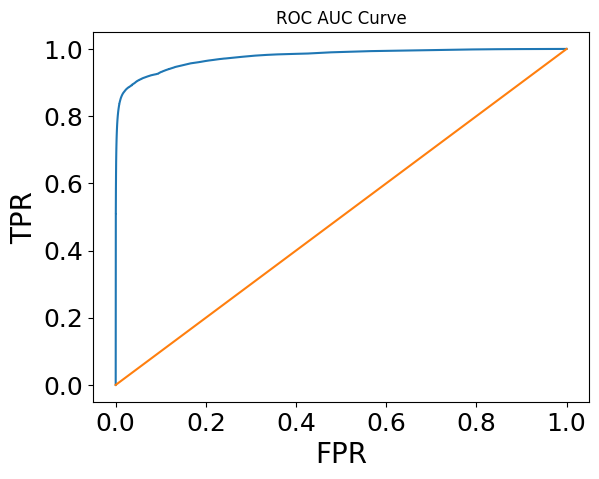

In [17]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [18]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.6192011287207124


In [148]:
i = 240000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.506 0.0005
0.578977051878833 0.0002424627527047138 0.5060173596474642


In [149]:
print(sum(predicted),len(predicted))

1849935.0 5013704


In [150]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.8740861496438773


In [151]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 40, 0, 10, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 40, 0, 10, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 40, 0, 10, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 40, 0, 10, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 40, 0, 10, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 40, 0, 10, 10, 0, 100)

In [152]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if ep>0.8 and n0>=2 and disp <5 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [153]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

8958015 4502526028 0.534 0.001 0.526 0.0 0.0 0.0


In [154]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

7.429 0.986 0.133 94927


In [155]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [156]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_s,"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_sd,"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

1501.0 3250.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [157]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [158]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[1. 1. 1. 0. 1. 1. 0. 0. 0. 1.]


In [159]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[1. 1. 1. 0. 1. 1. 0. 0. 0. 1.]


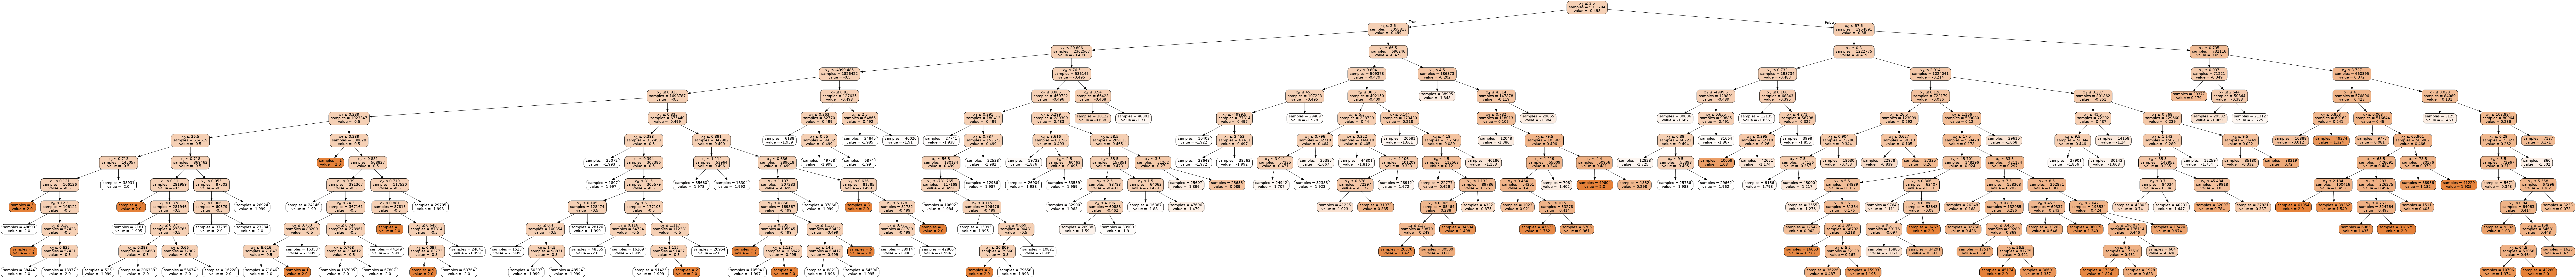

In [160]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [161]:
clf2.predict(kek_data[0:100])

array([1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])

In [162]:
clf2.predict_proba(kek_data[0:100])

array([[0.12591385, 0.87408615],
       [0.1556669 , 0.8443331 ],
       [0.07596618, 0.92403382],
       [0.91123302, 0.08876698],
       [0.01795978, 0.98204022],
       [0.0926292 , 0.9073708 ],
       [0.99139285, 0.00860715],
       [0.97876017, 0.02123983],
       [0.95692908, 0.04307092],
       [0.03356388, 0.96643612],
       [0.99115646, 0.00884354],
       [0.97350138, 0.02649862],
       [0.10565754, 0.89434246],
       [0.9257035 , 0.0742965 ],
       [0.01763352, 0.98236648],
       [0.98980383, 0.01019617],
       [0.96728874, 0.03271126],
       [0.99136594, 0.00863406],
       [0.59879552, 0.40120448],
       [0.86206799, 0.13793201],
       [0.08954188, 0.91045812],
       [0.9913335 , 0.0086665 ],
       [0.19514012, 0.80485988],
       [0.97004257, 0.02995743],
       [0.03986437, 0.96013563],
       [0.20782089, 0.79217911],
       [0.35772531, 0.64227469],
       [0.99123337, 0.00876663],
       [0.9280418 , 0.0719582 ],
       [0.03522568, 0.96477432],
       [0.

In [163]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}


In [164]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.03356388, 0.96643612],
       [0.99115646, 0.00884354],
       [0.97350138, 0.02649862],
       [0.10565754, 0.89434246],
       [0.9257035 , 0.0742965 ],
       [0.01763352, 0.98236648],
       [0.98980383, 0.01019617],
       [0.96728874, 0.03271126],
       [0.99136594, 0.00863406],
       [0.59879552, 0.40120448],
       [0.86206799, 0.13793201]])

In [165]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[ 2.33540386 -2.69041624 -2.14526251  1.56895354 -1.72283392  2.65405169
 -2.65913467 -2.2375355  -2.69336529 -0.73899308]
[-0.25190116 -7.39182985 -2.03647161  3.07469739 -2.77881332  6.73468071
 -6.11673395 -4.7945758  -7.43298314  3.25551411 -5.14963342]
[0.91176703 0.06354125 0.10477475 0.82763438 0.1515065  0.93426028
 0.06542823 0.09643006 0.06336599 0.32322437]


In [166]:
best_gbc = clf2.best_estimator_

In [167]:
n_estim = best_gbc.n_estimators

In [168]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 3.36016459 -4.71918508 -3.60380673  2.13588564 -2.52249015  4.02016265
 -4.575495   -3.38677761 -4.7433689  -0.40044894]
[0.96643612 0.00884354 0.02649862 0.89434246 0.0742965  0.98236648
 0.01019617 0.03271126 0.00863406 0.40120448]
0.2


In [169]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [170]:
print(log_odds_predictions)

[[2.0, -1.9988560503549686, -1.3839836154823322, 2.0, -1.2171877729257643, 2.0, -1.9916269703530327, -1.5899581589958158, -1.9995707324920369, -0.7530437699144725], [0.5554919940145532, -1.6691191535069598, -1.2792059056848102, 1.5769394493858964, -1.3737936551760215, 1.5598253402425644, -1.663250520917111, -1.5567463682744547, -1.6700380472419956, -0.4115470821851286], [1.4690855108847962, -1.4787081848651404, -1.4776089710406293, 0.8545904436054037, -1.3372458840724188, 1.5004037835667765, -1.477759486020024, -1.2885419837597545, -1.4795071971444047, -1.1280537738210576], [0.3886694783312467, -1.3554519612217302, -1.017017350763185, -0.8377529307346924, -1.180811221724735, 1.360552821959508, -1.3437535661577638, -1.313836994147374, -1.3561488166154918, -0.3423364593914036], [1.318780366000243, -1.2705193121139478, -0.9691064397277082, 1.3206397402832042, -0.3635529547135474, 1.2246166572456687, -1.256815513864915, -0.9917626977971729, -1.2716841377227983, -0.28994673777542673], [1.20

In [171]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 2.3354038599180877
[ 3.36016459 -4.71918508 -3.60380673  2.13588564 -2.52249015  4.02016265
 -4.575495   -3.38677761 -4.7433689  -0.40044894]


In [172]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[2.0, 0.5554919940145532, 1.4690855108847962, 0.3886694783312467, 1.318780366000243, 1.2049132695114118, 1.323306834703268, 1.2142791912158166, 0.9682889138034501, 1.2342037411256521, 0.9942936692134701, 0.7148239289732102, 1.240815639577139, 0.29141363674067855, 0.408531888316708, 0.16281929997361866, 0.2511677815920595, 0.9048395278092364, 0.511554188817314, -0.3564559178259274], [-1.9988560503549686, -1.6691191535069598, -1.4787081848651404, -1.3554519612217302, -1.2705193121139478, -1.2075563854588371, -1.162926539400674, -1.130288273818638, -1.0970934268469574, -1.0815619339659563, -1.0623693901418263, -1.052671729089877, -1.0336510671231385, -1.0312634307961428, -1.0195369340535234, -1.0185369255474193, -0.9694850322703339, -1.0084867099180146, -0.9987952504389217, -0.9490476892953542], [-1.3839836154823322, -1.2792059056848102, -1.4776089710406293, -1.017017350763185, -0.9691064397277082, -1.2015264709534919, -1.1101153817065894, -1.0234350417171825, -0.3748818626153865, -

In [173]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [174]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [175]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[3] > 3.5) if (x[0] > 57.5) if (x[2] > 0.73548) if (x[4] <= 3.7273) if (x[6] > 6.5) if (x[7] > 0.00829) if (x[5] <= 65.90144) if (x[0] > 65.5) if (x[2] <= 1.28296) if (x[2] > 0.76087)   return 2.0;  // | based on 318,679 samples
        if  (x[3] <= 3.5) if (x[3] <= 2.5) if (x[5] <= 20.80633) if (x[4] <= -4999.48487) if (x[2] <= 0.81288) if (x[7] <= 0.23903) if (x[0] > 26.5) if (x[2] <= 0.71762) if (x[1] > 0.10989) if (x[1] > 0.37772) if (x[7] <= 0.07459) if (x[1] > 0.39317)   return -1.9999517251303007;  // | based on 206,338 samples
        if  (x[3] > 3.5) if (x[0] <= 57.5) if (x[2] > 0.80046) if (x[4] <= 2.9139) if (x[7] > 0.12637) if (x[2] <= 1.1659) if (x[0] > 17.5) if (x[0] > 33.5) if (x[6] > 8.5) if (x[4] <= 2.64738) if (x[5] <= 196.03359) if (x[3] <= 7.5)   return 1.823594849709773;  // | based on 173,582 samples
        if  (x[3] <= 3.5) if (x[3] <= 2.5) if (x[5] <= 20.80633) if (x[4] <= -4999.48487) if (x[2] <= 0.81288) if (x[7] > 0

In [176]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [177]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[3] > 3.5) and (x[0] > 57.5) and (x[2] > 0.73548) and (x[4] <= 3.7273) and (x[6] > 6.5) and (x[7] > 0.00829) and (x[5] <= 65.90144) and (x[0] > 65.5) and (x[2] <= 1.28296) and (x[2] > 0.76087) :  return 2.0  # | based on 318,679 samples
        if (x[3] <= 3.5) and (x[3] <= 2.5) and (x[5] <= 20.80633) and (x[4] <= -4999.48487) and (x[2] <= 0.81288) and (x[7] <= 0.23903) and (x[0] > 26.5) and (x[2] <= 0.71762) and (x[1] > 0.10989) and (x[1] > 0.37772) and (x[7] <= 0.07459) and (x[1] > 0.39317) :  return -1.9999517251303007  # | based on 206,338 samples
        if (x[3] > 3.5) and (x[0] <= 57.5) and (x[2] > 0.80046) and (x[4] <= 2.9139) and (x[7] > 0.12637) and (x[2] <= 1.1659) and (x[0] > 17.5) and (x[0] > 33.5) and (x[6] > 8.5) and (x[4] <= 2.64738) and (x[5] <= 196.03359) and (x[3] <= 7.5) :  return 1.823594849709773  # | based on 173,582 samples
        if (x[3] <= 3.5) and (x[3] <= 2.5) and (x[5] <= 20.80633) and (x[4] <= -

In [178]:
def mytree(x,y):
    return 0

In [179]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [180]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [181]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[ 1.23420374 -1.08156193 -0.88943152 -0.3012583  -0.14243536  1.05525632
 -1.05256774 -0.72602255 -1.08156193 -0.67672694]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [182]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.03356388 0.96643612]
 [0.99115646 0.00884354]
 [0.97350138 0.02649862]
 [0.10565754 0.89434246]
 [0.9257035  0.0742965 ]
 [0.01763352 0.98236648]
 [0.98980383 0.01019617]
 [0.96728874 0.03271126]
 [0.99136594 0.00863406]
 [0.59879552 0.40120448]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [183]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1+hadron_weight
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1+hadron_weight
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    if counter<20: 
        print(proba_loc[counter],mygradboost(kek_data[0+counter:1+counter].values.tolist()[0]),mybdt(kek_data[0+counter:1+counter].values.tolist()[0],thresholds[i]),phi0)
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

[0.12591385 0.87408615] 0.5 None 1.0
[0.1556669 0.8443331] 0.5 None 1.0
[0.07596618 0.92403382] 0.5 None 1.0
[0.01795978 0.98204022] 0.5 None 1.0
[0.99139285 0.00860715] 0.5 None 0.0
[0.97876017 0.02123983] 0.5 None 1.0
[0.03356388 0.96643612] 0.5 None 1.0
[0.99115646 0.00884354] 0.5 None 1.0
[0.97350138 0.02649862] 0.5 None 1.0
[0.10565754 0.89434246] 0.5 None 1.0
[0.9257035 0.0742965] 0.5 None 1.0
[0.01763352 0.98236648] 0.5 None 1.0
[0.99136594 0.00863406] 0.5 None 0.0
[0.59879552 0.40120448] 0.5 None 1.0
[0.86206799 0.13793201] 0.5 None 1.0


ZeroDivisionError: float division by zero

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define parameters for GridSearch
parameters = {
    "loss": ["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [2, 5],
    "max_depth": [3, 8],
    "max_features": ["log2", "sqrt"],
    "criterion": ['friedman_mse'],
    "n_estimators": [1]
}

classif = GradientBoostingClassifier()
classif.set_params(init='zero')
# Create a GridSearchCV object
clf3 = GridSearchCV(classif, parameters, cv=2, n_jobs=1)

# Sample data
X_train = np.array([[0, 0], [1, 1], [0, 1], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [1, 1]])
y_train = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

# Fit the model
clf3.fit(X_train, y_train)

# Get the best estimator
best_estimator = clf3.best_estimator_
print(best_estimator.get_params())

# Get the initial prediction (base learner's output)
initial_prediction = 0#best_estimator.init_.predict(X_train)
# Convert initial predictions to probabilities
initial_probabilities = 1 / (1 + np.exp(-initial_prediction))
# Convert initial probabilities to log odds
initial_log_odds = np.log(initial_probabilities / (1 - initial_probabilities))

# Initialize an array for the decision function
manual_decision_function = initial_log_odds.copy()

# Iterate over trees in the best estimator
for tree in best_estimator.estimators_:
    # Get leaf indices for training data
    leaf_indices = tree[0].apply(X_train)
    
    # Get average values at each leaf (contributions)
    leaf_values = tree[0].tree_.value[:, 0, 0]  # Average target value for each leaf
    
    # Calculate contribution from this tree
    contribution = leaf_values[leaf_indices] * best_estimator.learning_rate
    
    # Accumulate contributions
    manual_decision_function += contribution

# Output the results
print("My Decision Function (Log Odds):", manual_decision_function)
print("Decision Function Output:", clf3.decision_function(X_train))
print("Decision Function other Output:", clf3.best_estimator_.decision_function(X_train))
print(X_train.shape[0])

# Calculate the differences
difference = np.abs(manual_decision_function - clf3.decision_function(X_train))
print("Differences:", difference)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': 'zero', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
My Decision Function (Log Odds): [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function other Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714

/home/yoren/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
kek

In [ ]:
# Cell 1: Import necessary libraries
import re

# Cell 2: Function to detect and clean redundant conditions
def clean_redundant_conditions(code):
    """
    This function searches for redundant conditions in if statements and removes them.
    Redundant conditions on the same variable are identified and weaker ones are removed.
    The function ensures that if no redundant conditions are found, the original if block remains.
    """
    def process_conditions(conditions):
        """Helper function to remove redundant conditions."""
        cleaned_conditions = {}
        
        for cond in conditions:
            # Match conditions like x[n] <= value, iestim == 0, etc.
            match = re.match(r'(x\[\d+\])\s*([<>!=]+)\s*(-?\d*\.?\d+)|(iestim\s*==\s*\d+)', cond)
            if match:
                variable, operator, value = match.groups()[:3]
                if variable and variable not in cleaned_conditions:
                    cleaned_conditions[variable] = cond
                elif variable:
                    prev_cond = cleaned_conditions[variable]
                    if is_stronger_condition(cond, prev_cond):
                        cleaned_conditions[variable] = cond
            else:
                # Non x[n] conditions (like iestim == 0) are directly added
                cleaned_conditions[cond] = cond

        # Return cleaned conditions or the original block if no redundancies
        return list(cleaned_conditions.values()) if cleaned_conditions else conditions
    
    def is_stronger_condition(cond1, cond2):
        """
        Compare two conditions on the same variable and determine if cond1 is stronger than cond2.
        Returns True if cond1 is stronger (i.e., it implies cond2), otherwise False.
        """
        match1 = re.search(r'([<>]=?)\s*(-?\d*\.?\d+)', cond1)
        match2 = re.search(r'([<>]=?)\s*(-?\d*\.?\d+)', cond2)
        
        if match1 and match2:
            operator1, value1 = match1.groups()
            operator2, value2 = match2.groups()
            value1, value2 = float(value1), float(value2)
            
            # Handle the comparison based on the operators
            if operator1 in ['<=', '<'] and operator2 in ['<=', '<']:
                return value1 <= value2  # Keep the stricter condition
            elif operator1 in ['>=', '>'] and operator2 in ['>=', '>']:
                return value1 >= value2
            elif operator1 in ['<=', '<'] and operator2 in ['>=', '>']:
                return value1 >= value2  # cond1 is stronger if it's stricter
            elif operator1 in ['>=', '>'] and operator2 in ['<=', '<']:
                return value1 <= value2
        return False
    
    # Regular expression to find if statements with conditions
    condition_block_pattern = r'if\s*\((.*?)\)\s*return'
    
    # Match all if statements
    matches = re.findall(condition_block_pattern, code, re.DOTALL)
    
    cleaned_code = code
    for match in matches:
        # Extract all individual conditions (x[n] <>, iestim ==, etc.)
        conditions = re.findall(r'(x\[\d+\]\s*[<>!=]+\s*-?\d*\.?\d+|iestim\s*==\s*\d+)', match)
        
        if conditions:
            # Process conditions and remove redundant ones
            cleaned_conditions = process_conditions(conditions)
            
            # Ensure that at least one condition is kept
            cleaned_if_block = ' && '.join(cleaned_conditions) if cleaned_conditions else match
            
            # Replace the original if statement with the cleaned one
            cleaned_code = cleaned_code.replace(match, cleaned_if_block)
    
    return cleaned_code

# Cell 3: Load the code from a file
def load_code(file_path):
    with open(file_path, 'r') as f:
        code = f.read()
    return code

# Cell 4: Save the cleaned code to a new file
def save_code(file_path, cleaned_code):
    with open(file_path, 'w') as f:
        f.write(cleaned_code)

# Cell 5: Process the function in the file
# Load the file contents
file_path = 'QACuts.C'
code = load_code(file_path)

# Identify and clean redundant conditions
cleaned_code = clean_redundant_conditions(code)

# Save the cleaned code to a new file
output_file_path = 'QACuts_cleaned.C'
save_code(output_file_path, cleaned_code)

# Display the cleaned code for confirmation
print(cleaned_code)


In [ ]:
# Cell 1: Import necessary libraries
import re

# Cell 2: Function to detect and clean redundant conditions, handling contradictions
def clean_redundant_conditions(code):
    """
    This function searches for redundant conditions in if statements and removes them.
    Conditions defining valid ranges (e.g., x[n] > a && x[n] <= b) are preserved as ranges.
    Redundant conditions (like x[n] <= a && x[n] <= b) are cleaned up.
    """
    def process_conditions(conditions):
        """Helper function to remove redundant conditions, preserving ranges and handling contradictions."""
        condition_map = {}
        
        for cond in conditions:
            # Match conditions like x[n] <= value, x[n] > value, iestim == 0, etc.
            match = re.match(r'(x\[\d+\])\s*([<>]=?)\s*(-?\d*\.?\d+)|(iestim\s*==\s*\d+)', cond)
            if match:
                variable, operator, value = match.groups()[:3]
                if variable:
                    if variable not in condition_map:
                        condition_map[variable] = []
                    condition_map[variable].append((operator, float(value), cond))  # Store operator, value, and full condition
            else:
                # Handle non-variable conditions like iestim == 0
                condition_map[cond] = [(None, None, cond)]
        
        cleaned_conditions = []
        for variable, conds in condition_map.items():
            if len(conds) > 1:
                # Handle the removal of redundant or contradictory conditions
                min_upper_bound = float('inf')
                max_lower_bound = float('-inf')
                final_conditions = []

                for operator, value, full_cond in conds:
                    if operator in ['<=', '<']:
                        if value < min_upper_bound:
                            min_upper_bound = value
                    elif operator in ['>=', '>']:
                        if value > max_lower_bound:
                            max_lower_bound = value
                    else:
                        final_conditions.append(full_cond)

                # Add upper and lower bounds to final conditions
                if max_lower_bound != float('-inf'):
                    final_conditions.append(f"{variable} > {max_lower_bound}")
                if min_upper_bound != float('inf'):
                    final_conditions.append(f"{variable} <= {min_upper_bound}")

                cleaned_conditions.extend(final_conditions)
            else:
                # If only one condition exists, just keep it
                cleaned_conditions.append(conds[0][2])  # Append the full condition
        
        return cleaned_conditions

    # Regular expression to find if statements with conditions
    condition_block_pattern = r'if\s*\((.*?)\)\s*return'
    
    # Match all if statements
    matches = re.findall(condition_block_pattern, code, re.DOTALL)
    
    cleaned_code = code
    for match in matches:
        # Extract all individual conditions (x[n] <>, iestim ==, etc.)
        conditions = re.findall(r'(x\[\d+\]\s*[<>!=]+\s*-?\d*\.?\d+|iestim\s*==\s*\d+)', match)
        
        if conditions:
            # Process conditions and remove redundant ones
            cleaned_conditions = process_conditions(conditions)
            
            # Ensure that at least one condition is kept
            cleaned_if_block = ' && '.join(cleaned_conditions) if cleaned_conditions else match
            
            # Replace the original if statement with the cleaned one
            cleaned_code = cleaned_code.replace(match, cleaned_if_block)
    
    return cleaned_code

# Cell 3: Load the code from a file
def load_code(file_path):
    with open(file_path, 'r') as f:
        code = f.read()
    return code

# Cell 4: Save the cleaned code to a new file
def save_code(file_path, cleaned_code):
    with open(file_path, 'w') as f:
        f.write(cleaned_code)

# Cell 5: Process the function in the file
# Load the file contents
file_path = 'QACuts.C'
code = load_code(file_path)

# Identify and clean redundant conditions
cleaned_code = clean_redundant_conditions(code)

# Save the cleaned code to a new file
output_file_path = 'QACuts_cleaned.C'
save_code(output_file_path, cleaned_code)

# Display the cleaned code for confirmation
print(cleaned_code)


#include "Run14AuAuLeptonCombyReco.h"

void Run14AuAuLeptonCombyReco::InitParams()
{
    BBC_VERTEX_CUT = 10;
    TRIGGERBIT = 4; // 4 - BBCLL1(>1 tubes) narrowvtx, 5 - BBCLL1(>1 tubes), 6 - BBCLL1(>1 tubes) novertex
    E_PT = 0.2;    // 0.15 in RDanalyzer for simulation to study smearing effect
    MAX_PT = 10;
    QUALITY[0] = 31;
    QUALITY[1] = 51;
    QUALITY[2] = 63;
    Z_GLOBAL = 75;
    DC_DEADMAP = 0; // by default, DC deadmap is on
    N0 = 2;
    DISP = 5;
    CHI2_NPE0 = 10;
    EOVERP = -999;
    DEP[0] = -2; // -2, can be applied offline
    DEP[1] =  5;  // 5
    PROB = 0.01; // 0.01
    TEMC = 5;
    EMCDPHI = 0.05; // ~5 sigma 0.05
    EMCDZ = 25;     // ~5 sigma 25
    EMCSDPHI = 5;   // remove sigmalized cut for Run14AuAu because the recalibrator doesn't work for simulation
    EMCSDZ = 5;
    RICH_GHOST = 10; // by default, RICH ghost cut is off

    std::cout << "Run14AuAuCut loaded... " << std::endl;
    std::cout << "***Event selection*** " << std::endl;
    s